In [1]:
#importing all libraries and packages that are used 
import pandas as pd
import pvlib
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy
import warnings
import pypyodbc as odbc
import numpy as np

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size']=12
plt.rcParams['lines.linewidth']=1.25
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.titlesize']=12

In [2]:
#import data from sql

DRIVER_NAME = 'SQL Server'
SERVER_NAME = 'PARTLABHMI'
DATABASE_NAME = 'IgnitionTest4'
table_name = 'dbo.sqlt_data_1_2023_09'

connection_string = f"""
    DRIVER={{{DRIVER_NAME}}};
    SERVER={SERVER_NAME};
    DATABASE={DATABASE_NAME};
    Trust_Connection =yes;
    uid=GradStudent;
    pwd=1000W/m2;
"""
conn = odbc.connect(connection_string)
lasel_cursor = conn.cursor()

lasel_cursor.execute('SELECT * FROM dbo.sqlth_te')
tag_id = []
for row in lasel_cursor:
    tag_id.append(row)
tag_id = pd.DataFrame(tag_id, columns=['tag','description','scid','datatype','querymode','created','retired'])

lasel_cursor.execute(f"select * from {table_name}")
data = []
for row in lasel_cursor:
    data.append(row)
df = pd.DataFrame(data, columns=['tag','intvalue','floatvalue','stringvalue','datevalue','dataintegrity','TmStamp'])

df['description'] = np.nan
for tag in tag_id.tag.unique():
    df.loc[df['tag'] == tag, 'description'] = tag_id.loc[tag_id.tag == tag]['description'].to_string(index=False)
    
df['TmStamp'] = pd.to_datetime(df.TmStamp, unit='ms')
df['TmStamp'] = df['TmStamp'] - timedelta(hours=5)
df.index = df['TmStamp']
df.index = df.index.tz_localize('America/Chicago', ambiguous='infer')

df_float = df.loc[df['floatvalue'].notnull()]
df_float = df_float.pivot(index='TmStamp', columns='description', values='floatvalue')
df_float_min = df_float.resample('T').mean()
df_float_min.index = df_float_min.index.tz_localize('America/Chicago')

In [6]:
param = 'drakerreal/inv10_dc_power'
availability = 100*(1-(df_float_min[param].isna().sum()/len(df_float_min[param])))
print('Overall availability for '+param+' is '+str(round(availability,3))+' %')

Overall availability for drakerreal/inv10_dc_power is 35.37 %


Text(0, 0.5, 'weatherstation/temperaturec (℃)')

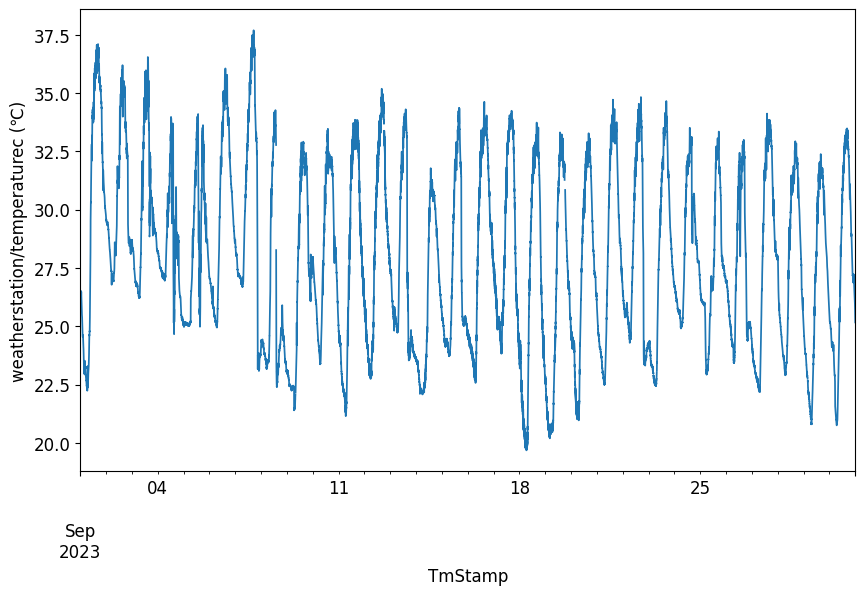

In [3]:
param = 'weatherstation/temperaturec'
df_float_min[param].plot()
plt.ylabel((str(param)+str(' (℃)'))) 

Text(0.5, 0, 'Time')

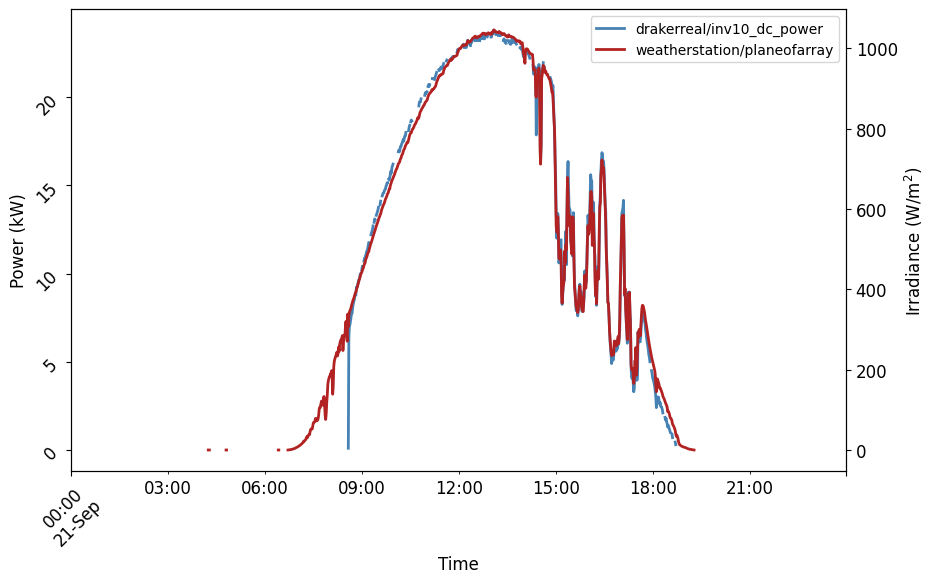

In [4]:
#diurnal plot - assuming two different unit parameters - can change parameters to any column in the df
date = '2023-09-21'
param_1 = 'drakerreal/inv10_dc_power'
param_2 = 'weatherstation/planeofarray'

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
df_float_min.loc[date, param_1].plot(ax=ax1, label=param_1, linewidth=2, color='steelblue', zorder=5.5)
df_float_min.loc[date, param_2].plot(ax=ax2, label=param_2, linewidth=2, color='firebrick', zorder=5.5)

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label=param_1)
line_2 = Line2D([0], [0], color='firebrick', linewidth=2, linestyle='-',label=param_2)
lines = [line_1,line_2]
plt.legend(prop=dict(size='small'),handles=lines)
ax1.set_ylabel('Power (kW)') 
ax1.tick_params(labelrotation=45)
ax2.set_ylabel('Irradiance (W/m$^2$)')
ax1.set_xlabel('Time')